In [3]:
# Path & Libraries

import sys 
import os 
import warnings

sys.path.append(os.path.abspath('dss'))
warnings.filterwarnings('ignore')

from dss.package import dss_package
import numpy as np
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

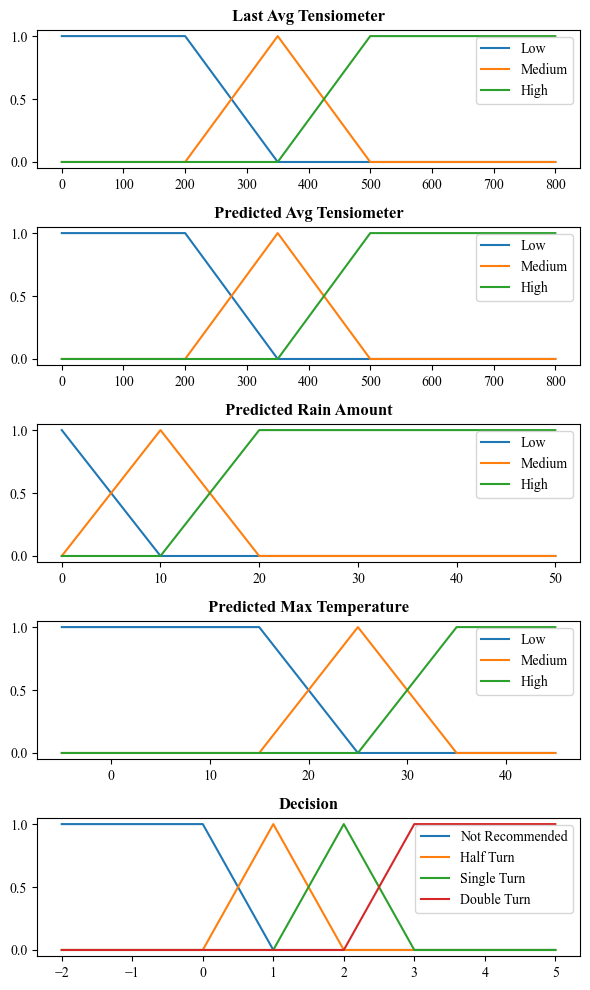

In [9]:
# Data Loading & Processing

rules_excel_path = '../data/dss_rules.xlsx'
sheet_names = ['Rules', 'Crispy Values', 'Fuzzy Values']

rules_df, crispy_df, fuzzy_df = [pd.read_excel(rules_excel_path, sheet_name=sheet) for sheet in sheet_names]
feature_names = fuzzy_df.iloc[:, :].columns[:].tolist()
rules_df = rules_df.iloc[:, :].rename(columns=lambda x: x.lower().replace(' ', '_'))
fuzzy_df = fuzzy_df.iloc[:, :].rename(columns=lambda x: x.lower().replace(' ', '_'))


# DSS Architecture

# Fuzzy Input Variables (Universe & Membership Functions)

input_variables = rules_df.columns[:-1].tolist()
crispy_input = crispy_df.iloc[:, 0].dropna().values
crispy_output = crispy_df.iloc[:, 1].dropna().values

fuzzy_values = fuzzy_df.values
fuzzy_lower = fuzzy_values[0].astype(float)
fuzzy_min = fuzzy_values[1].astype(float)
fuzzy_max = fuzzy_values[2].astype(float)
fuzzy_upper = fuzzy_values[3].astype(float)
num_classes = fuzzy_values[4].astype(float)

feature_dict = {}
universe_dict = {}

for var, lower, min_val, max_val, upper, num_class in zip(input_variables, fuzzy_lower[:-1], fuzzy_min[:-1],
                                                          fuzzy_max[:-1], fuzzy_upper[:-1], num_classes[:-1]):
    feature_dict[var] = {}
    fraction_range = (max_val - min_val) / (num_class - 1)
    universe = np.arange(lower, upper + 1, 1)
    universe_dict[var] = universe
    for i, term_name in enumerate(crispy_input):
        if i == 0:
            feature_dict[var] = ctrl.Antecedent(universe, var)
            term_range = [lower, lower, min_val, min_val + fraction_range]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        elif i == num_class - 1:
            term_range = [max_val - fraction_range, max_val, upper, upper]
            feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
        else:
            term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range,
                          min_val + (i + 1) * fraction_range]
            feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)

# Fuzzy Output Variable

output_variable = rules_df.columns[-1]

var = output_variable
lower = fuzzy_lower[-1].astype(float)
min_val = fuzzy_min[-1].astype(float)
max_val = fuzzy_max[-1].astype(float)
upper = fuzzy_upper[-1].astype(float)
num_class = num_classes[-1].astype(float)

feature_dict[var] = {}
fraction_range = (max_val - min_val) / (num_class - 1)
universe = np.arange(lower, upper + 1, 1)
universe_dict[var] = universe
for i, term_name in enumerate(crispy_output):
    if i == 0:
        feature_dict[var] = ctrl.Consequent(universe, var)
        term_range = [lower, lower, min_val, min_val + fraction_range]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    elif i == num_class - 1:
        term_range = [max_val - fraction_range, max_val, upper, upper]
        feature_dict[var][term_name] = fuzz.trapmf(feature_dict[var].universe, term_range)
    else:
        term_range = [min_val + (i - 1) * fraction_range, min_val + i * fraction_range,
                      min_val + (i + 1) * fraction_range]
        feature_dict[var][term_name] = fuzz.trimf(feature_dict[var].universe, term_range)


# Fuzzy Variables Visualization
plt.rcParams.update({'font.family': 'Times New Roman'})

n_parameters = rules_df.shape[1] - 1
num_rows = math.ceil(len(feature_dict))

fig, axs = plt.subplots(nrows=num_rows, ncols=1, figsize=(6, 10))

for idx, (var, ax) in enumerate(zip(feature_dict, axs.flatten())):
    for term_name, term in feature_dict[var].terms.items():
        values = term.mf
        ax.plot(universe_dict[var], values, label=term_name)
    
    ax.set_title(format(feature_names[idx]), fontweight='bold')
    ax.legend()

# Remove Useless Plots
for ax in axs.flatten()[len(feature_dict):]:
    ax.remove()

plt.tight_layout()
output_path = 'fuzzy_variables.png'
plt.savefig(output_path, dpi=400)
plt.show()

In [13]:
# Fuzzy Rules

rule_dict = {}

n_rules = rules_df.shape[0]
n_features = rules_df.shape[1]

for i in range(n_rules):
    term_input = None
    term_output = None

    for j in range(n_features):

        if j == 0:
            term_input = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif j == n_features - 1:
            term_output = feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        elif not pd.isna(rules_df.iloc[i, j]):
            term_input = term_input & feature_dict[rules_df.columns.tolist()[j]][rules_df.iloc[i, j]]

        else:
            continue

    rule_dict[i] = ctrl.Rule(antecedent=term_input, consequent=term_output)

#rule_dict[0].view() # plotting the graph of a specific rule


# Control System Creation & Simulation

rule_vector = []
for i in range(len(rule_dict)):
    rule_vector.append(rule_dict[i])

dss_ctrl = ctrl.ControlSystem(rule_vector)
dss = ctrl.ControlSystemSimulation(dss_ctrl, flush_after_run=100 * 100 + 1)

In [14]:
# Control Space

plt.rcParams.update({
    'axes.labelsize': 18,  # Dimensione dei label degli assi
    'axes.titlesize': 24,  # Dimensione del titolo
    'xtick.labelsize': 12,  # Dimensione dei tick sull'asse X
    'ytick.labelsize': 12   # Dimensione dei tick sull'asse Y
})

dss_package.create_plot_interface(dss)

Button(description='Compute', style=ButtonStyle())

Output()

In [8]:
# Recommendation

dss_package.create_decision_interface(dss, rules_df, n_parameters)

Button(description='Compute', style=ButtonStyle())

Output()